# Pair trading exercise 1

In [2]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Stock Universe and Identification of Cointegrated Pairs of Stocks

In [3]:
# read the matadata csv
nifty_meta = pd.read_csv('data/nifty_meta.csv')
nifty_meta.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
2,Adani Transmission Ltd.,POWER,ADANITRANS,EQ,INE931S01010
3,Ambuja Cements Ltd.,CEMENT & CEMENT PRODUCTS,AMBUJACEM,EQ,INE079A01024
4,Ashok Leyland Ltd.,AUTOMOBILE,ASHOKLEY,EQ,INE208A01029


In [4]:
# get the ticker list with industry is equal to FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry=='FINANCIAL SERVICES'].Symbol)
print(tickers)
print(len(tickers))

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'GICRE', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'IBULHSGFIN', 'INDUSINDBK', 'KOTAKBANK', 'L&TFH', 'PEL', 'PFC', 'PNB', 'SBILIFE', 'SRTRANSFIN', 'SBIN', 'NIACL']
25


In [5]:
# start and end dates for backtesting
fromdate = datetime.datetime(2010, 1, 1)
todate = datetime.datetime(2020, 6, 15)

In [6]:
# read back the pricing data
prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'], parse_dates=True)
prices.head(2)

/tmp/ipykernel_9641/3176423794.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'], parse_dates=True)


open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934

In [7]:
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38580 entries, ('AXISBANK', Timestamp('2010-01-04 00:00:00')) to ('SRTRANSFIN', Timestamp('2020-06-15 00:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    38579 non-null  float64
 1   high    38579 non-null  float64
 2   low     38579 non-null  float64
 3   close   38579 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB


In [8]:
# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)

15
['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']


In [10]:
# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head()

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904
2010-01-06,141.236801,340.480804,491.044189,16.153118,53.009216,433.299774,134.453751,86.789574,136.796616,206.915863,265.181671,62.333515,85.847481,95.672699,418.562897
2010-01-07,142.236725,337.819672,481.012695,16.054960,53.326965,425.232697,134.803970,85.970222,133.706726,209.240005,265.935547,62.381512,84.668106,95.137444,431.439545
2010-01-08,144.094727,338.787170,478.753693,16.347025,53.540455,417.824463,134.981079,84.762535,133.238586,207.948059,265.181671,62.033478,84.792007,94.853218,440.510895


In [11]:
# train test split 
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

In [14]:
# quick view of head and tail of train set
pd.concat([train_close.head(2), train_close.tail(2)])

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904
2015-03-18,565.011414,1429.524780,1232.434326,373.762146,176.891403,746.211670,504.396698,281.529602,876.665283,668.962646,776.118347,101.667664,164.392944,277.530243,1108.600708
2015-03-19,547.805969,1404.615723,1244.039917,372.603363,171.310471,746.211670,499.013824,277.661316,855.263062,660.394348,777.710266,100.663200,157.955719,272.024109,1115.327637


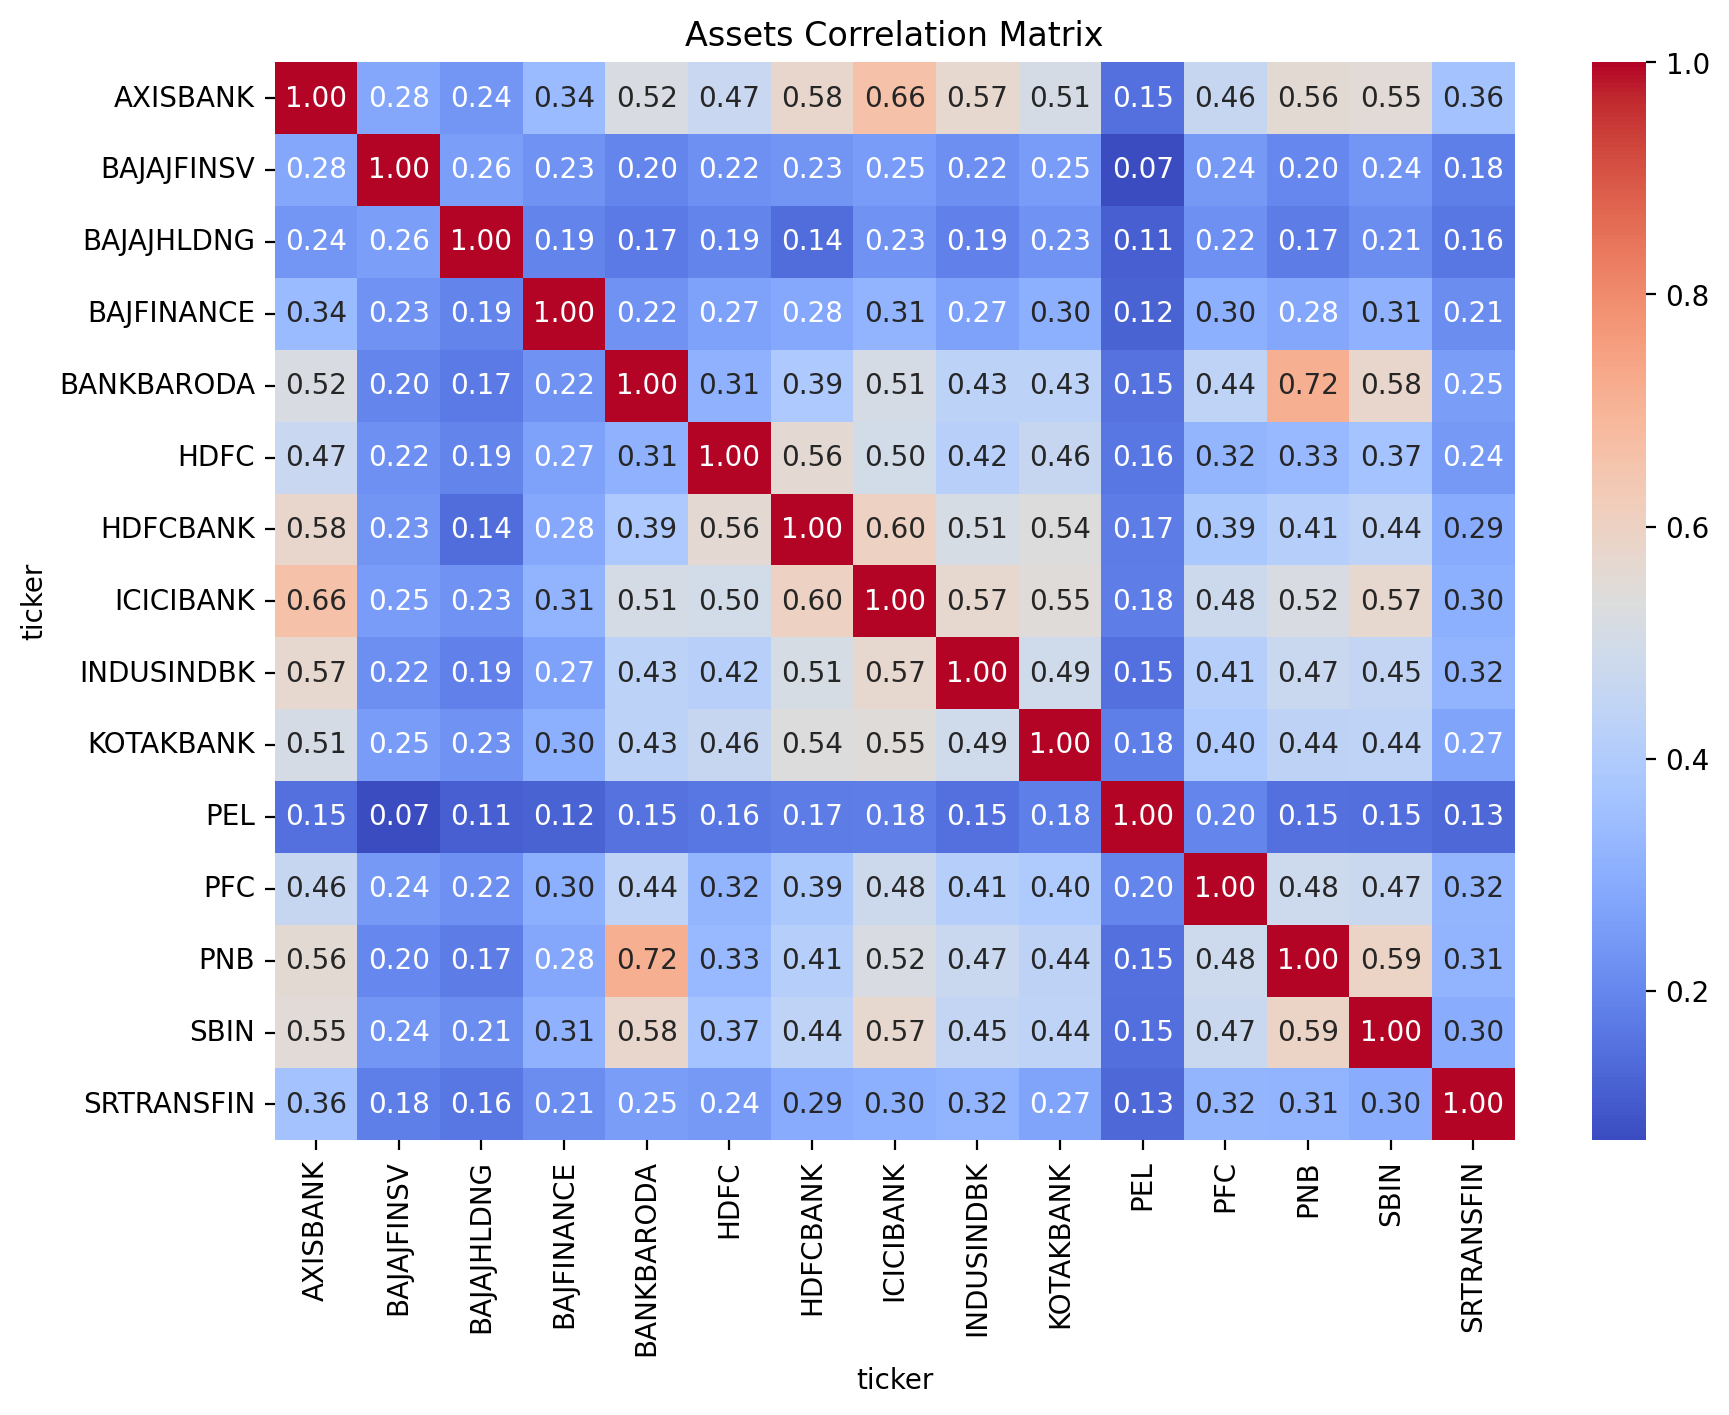

In [16]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300)

Now we do teh following 
* Define a function find_cointegrated_pairs to find cointegrated pairs and corresponding p-values.
* Plot the heatmap of p-values.

In [17]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOTAKBANK'), ('INDUSINDBK', 'PEL'), ('KOTAKBANK', 'PEL'), ('PEL', 'SBIN')]


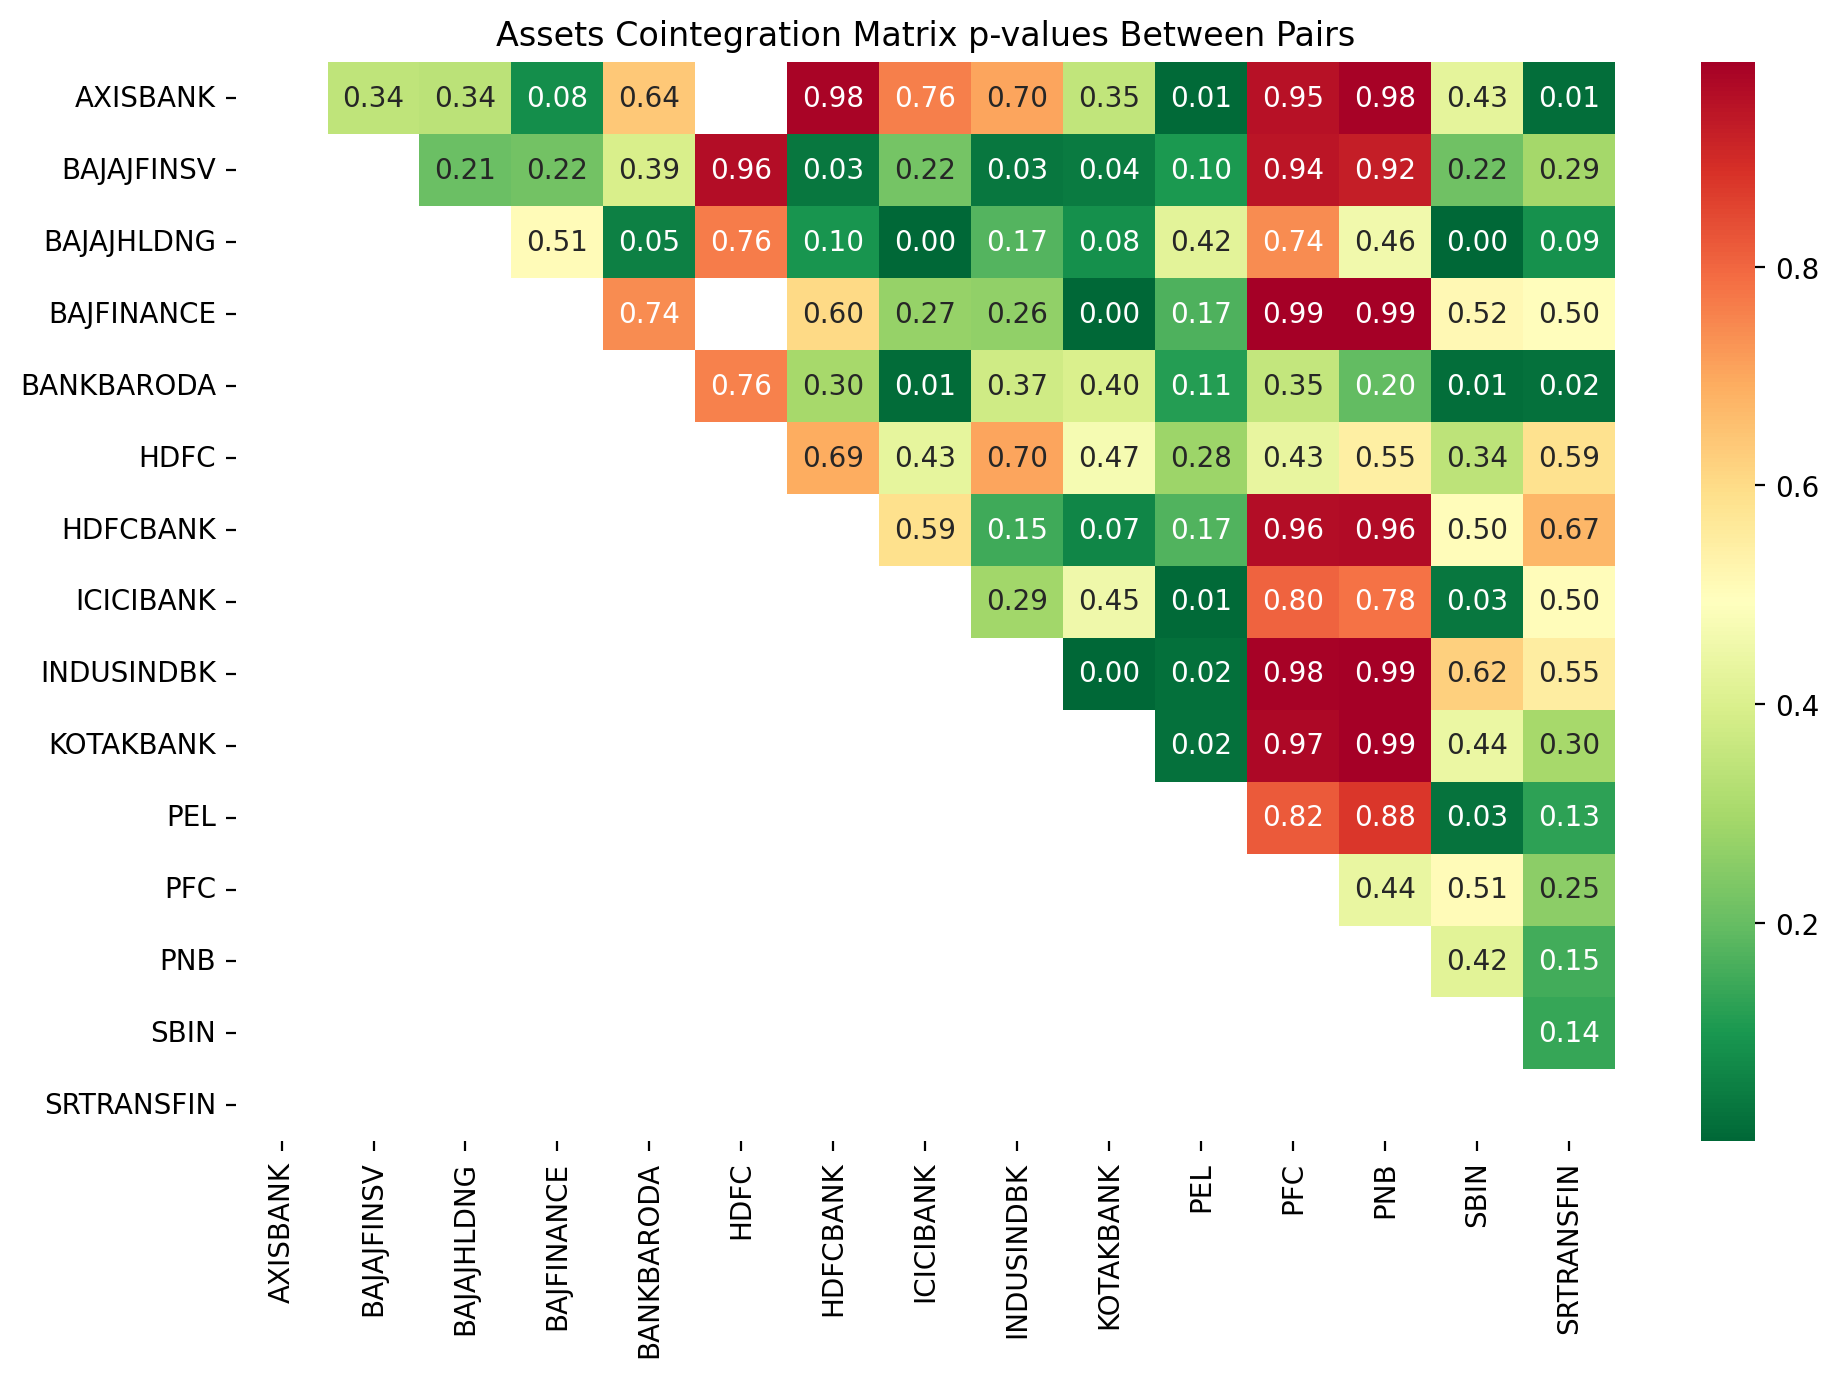

In [18]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300) 

## Perform Stationary test for the Selected Pair

Now, we have many candidates of pairs for the strategy where the p-value is less than 0.05. Selecting the right pair is of the utmost importance as the strategy will not work well if the prices are moving exactly together. They need to be diverging and mean-reverting for our strategy to be profitable.

Let’s go with tickers BANKBARODA and SBIN and further test the stationarity of spread using the Augmented Dickey-Fuller test. It is important that the spread is stationary. A time series is considered stationary if parameters such as mean and variance do not change over time and there is no unit root. We will first calculate the hedge ratio between these two tickers using OLS regression. Then, using the hedge ratio, we will calculate the spread and run the Augmented Dickey-Fuller test.

In [19]:
# final pair to test strategy
asset1 = 'BANKBARODA'
asset2 = 'SBIN'

In [20]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

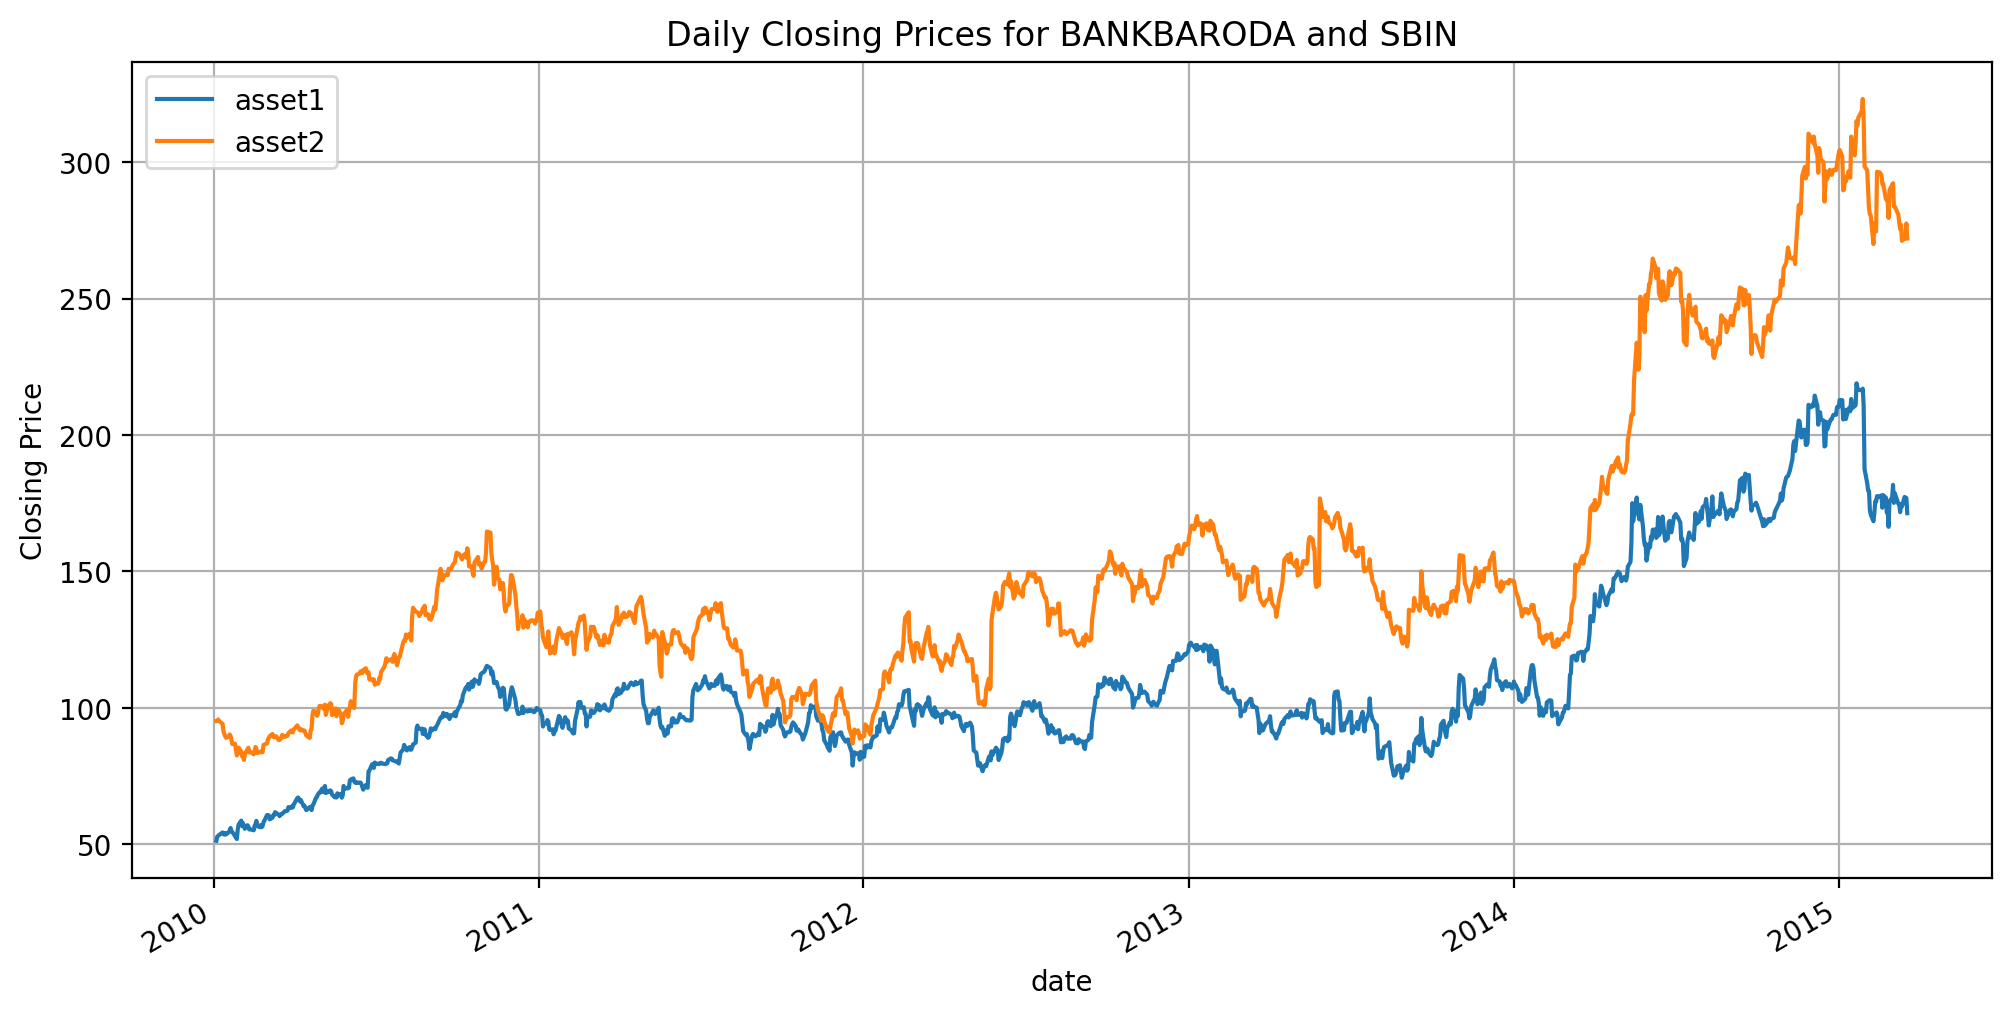

In [21]:
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('images/chart3', dpi=300) 

Run OLS regression and get the slope coefficient which is also our hedge ratio.

In [22]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

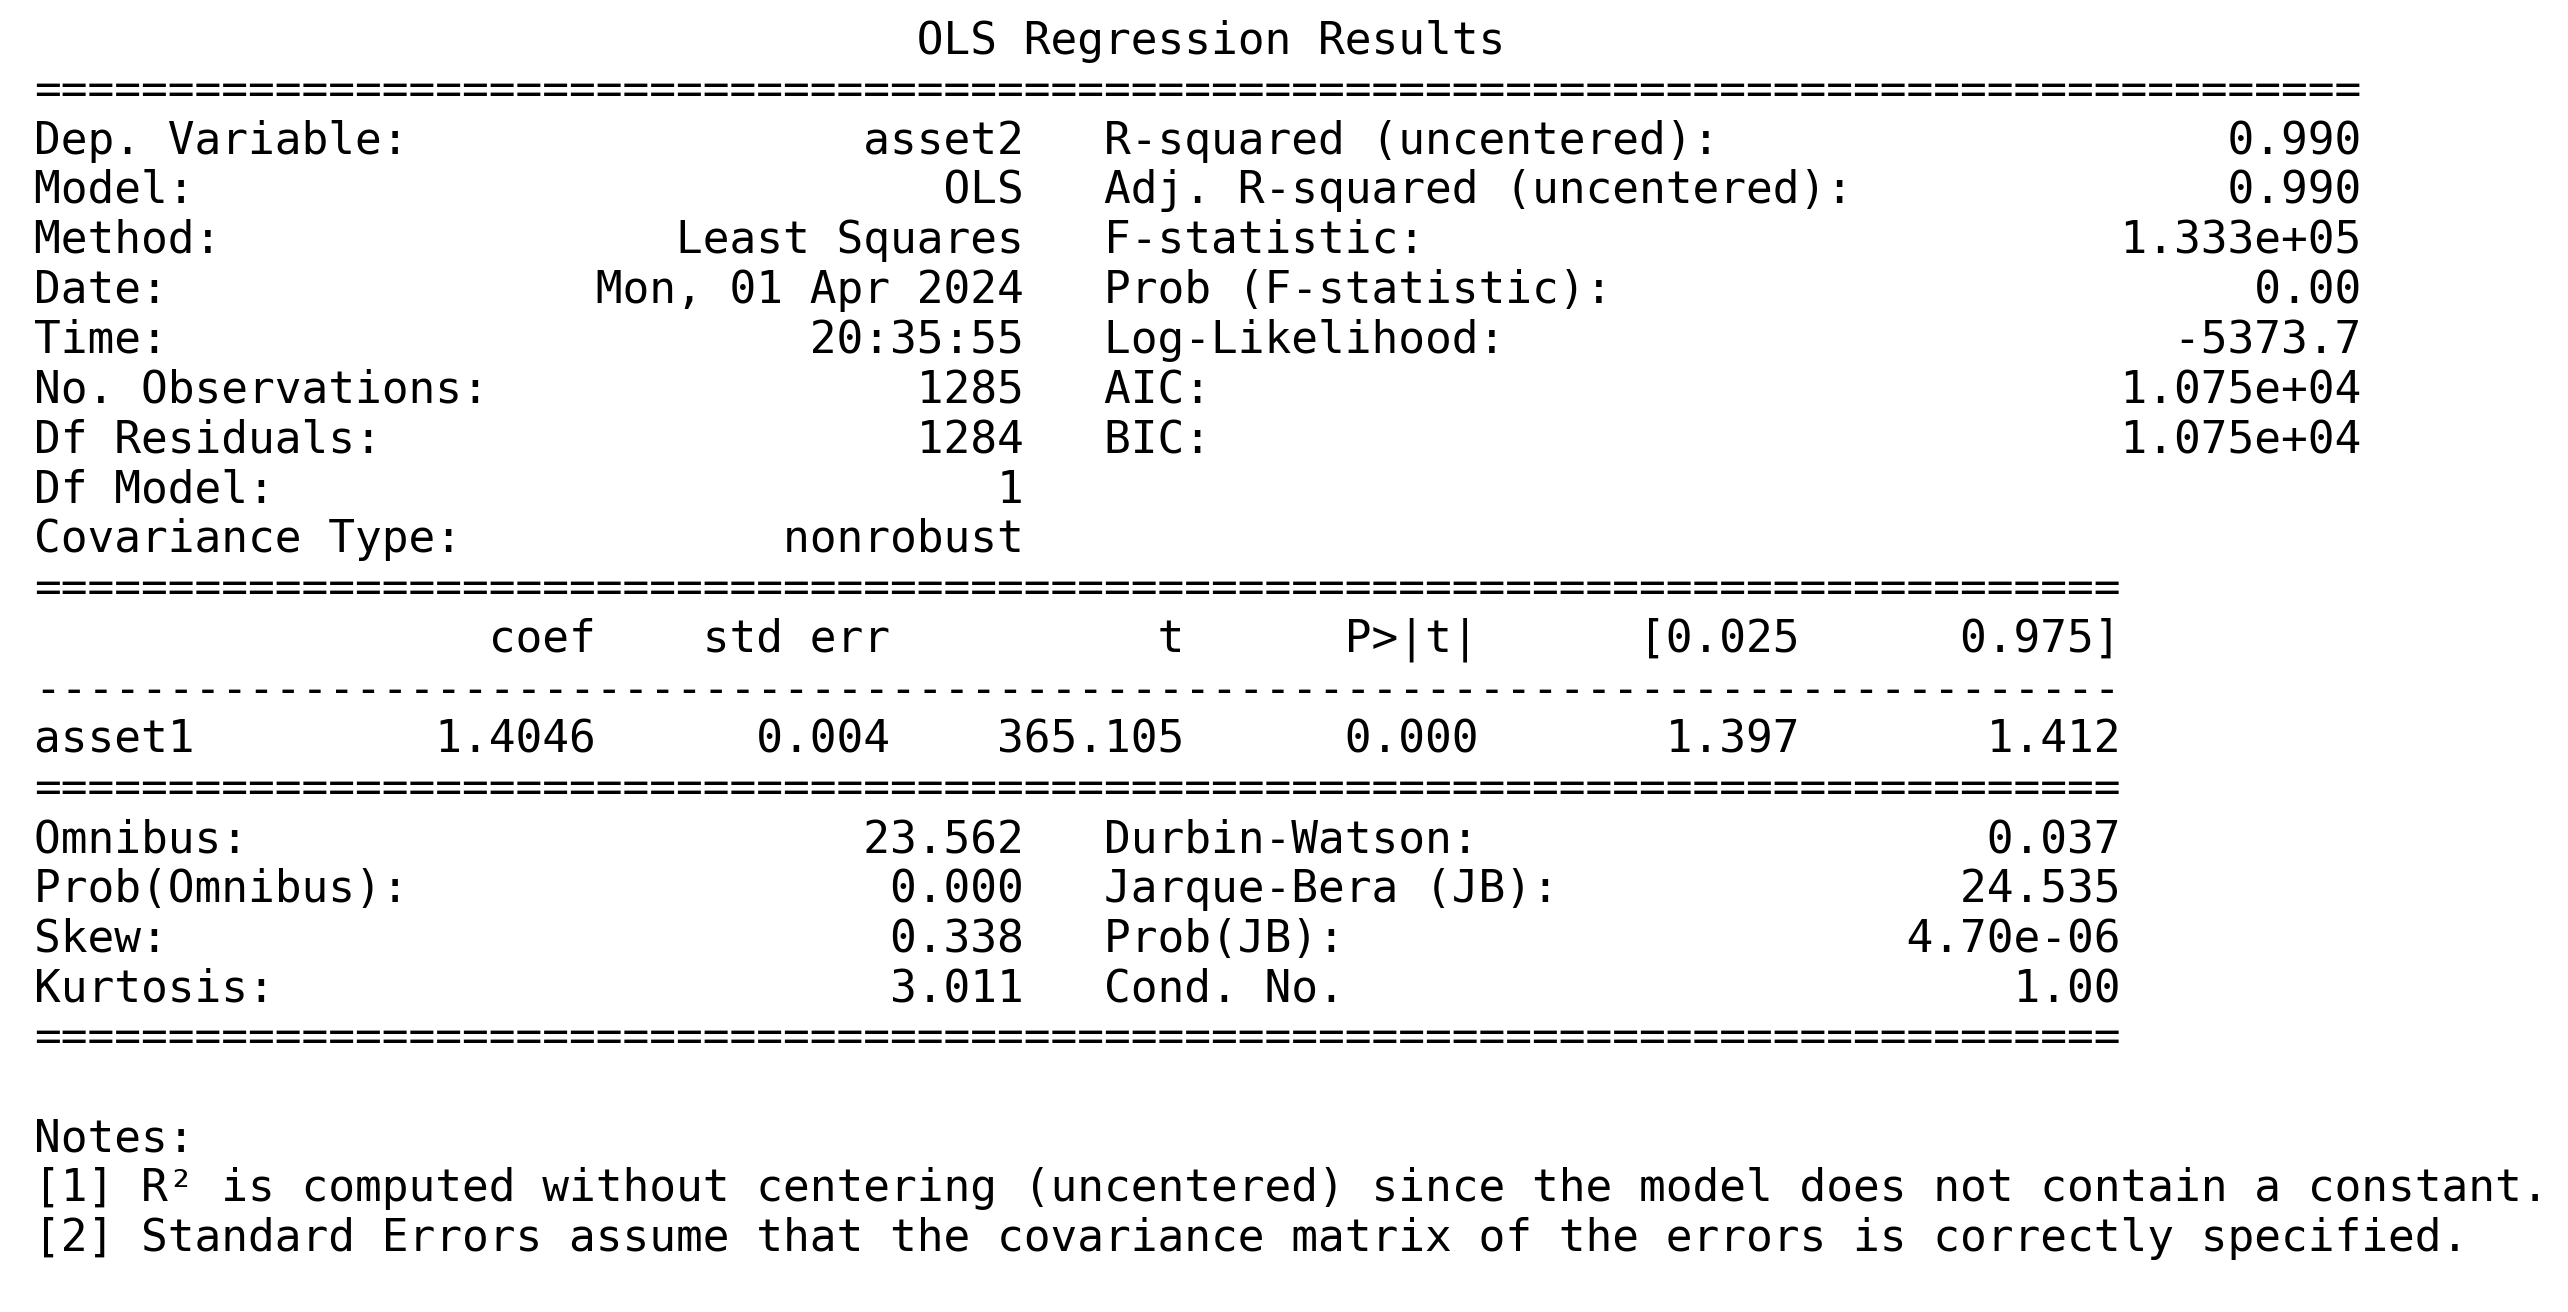

In [23]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300);

In [24]:
print('Hedge Ratio = ', model.params[0])


Hedge Ratio =  1.4046459680586496


/tmp/ipykernel_9641/4198730175.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Hedge Ratio = ', model.params[0])


In [25]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

/tmp/ipykernel_9641/10101694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = train.asset2 - model.params[0] * train.asset1


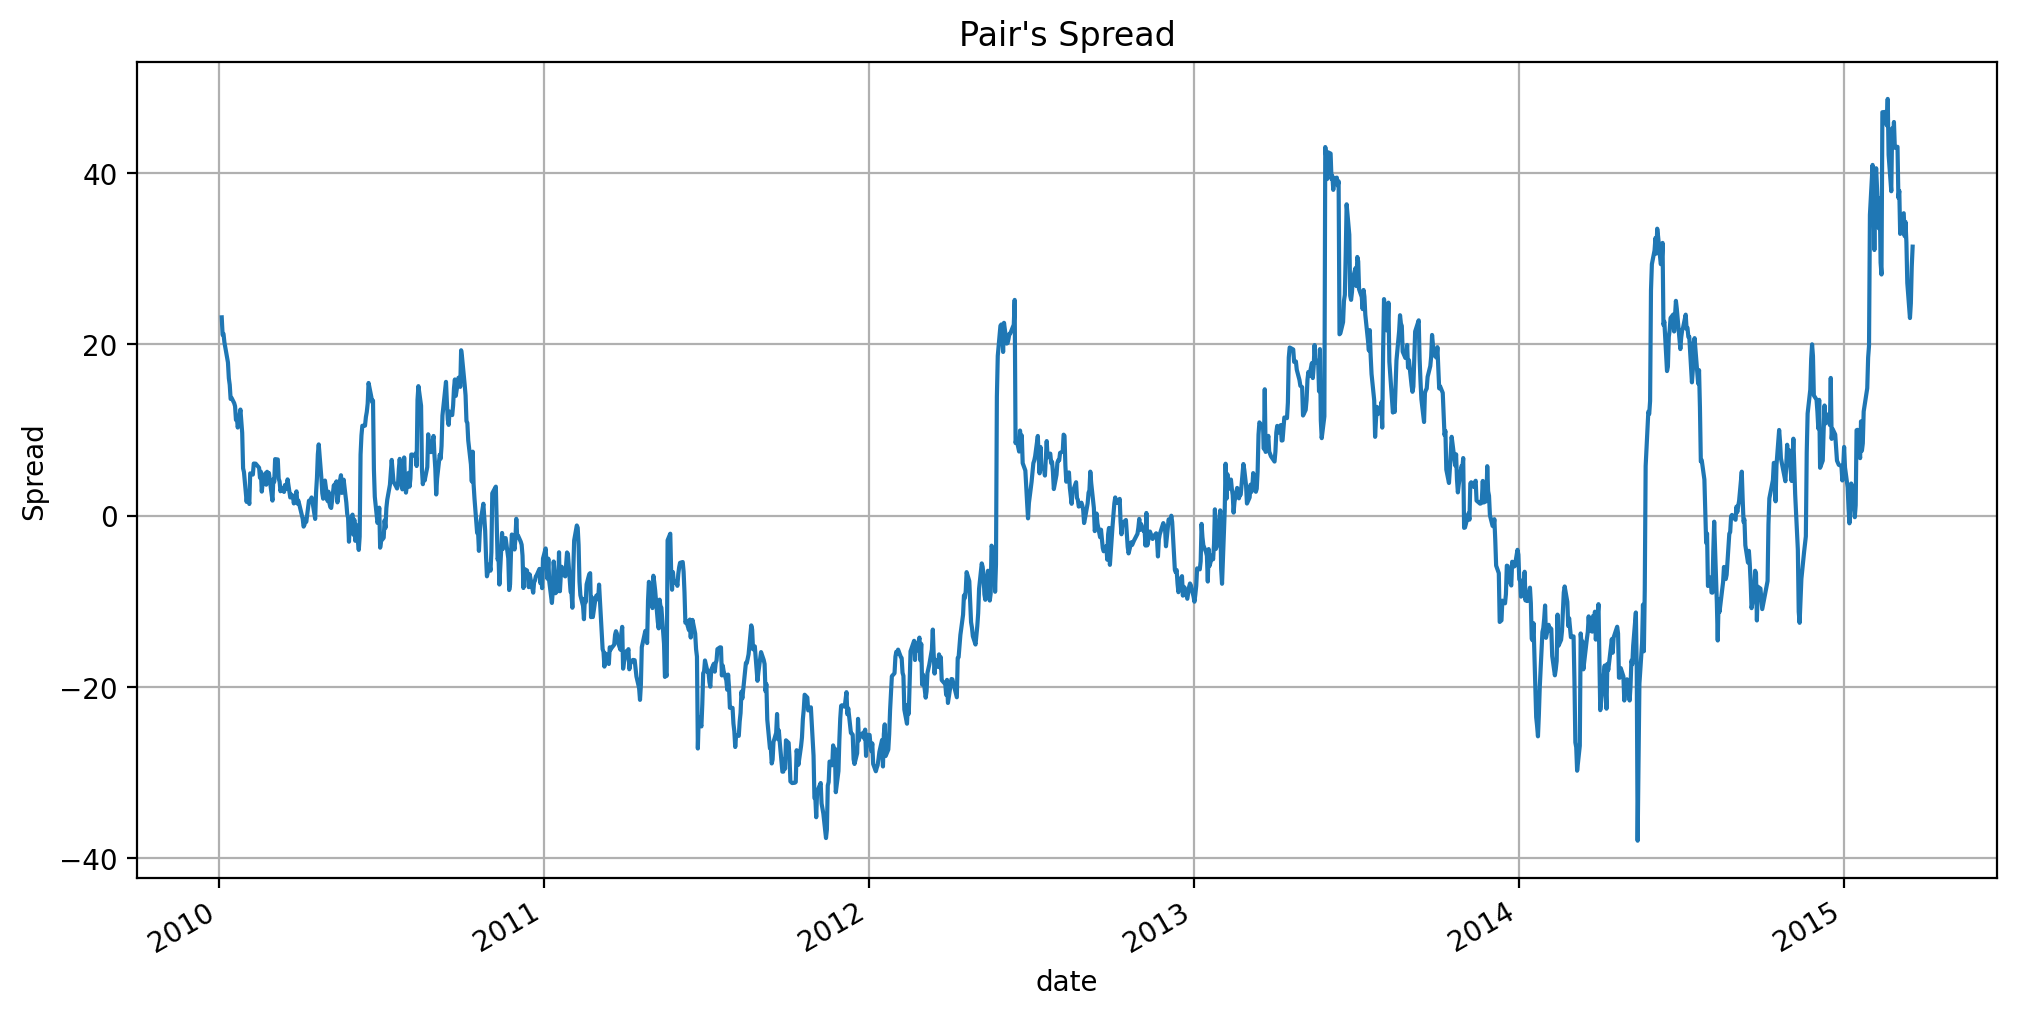

In [26]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('images/chart5', dpi=300);

In [27]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.4590476442921587


In [28]:
# probablity critical values
print(adf[4])

{'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}


## Generate Trading Signals using z-score


We have used the training dataset until this point to finalize the stock pair for our strategy. Now onward we will be using the test dataset to ensure trading signal generation and backtesting is using out of sample dataset. We will use the z-score of the ratio between the two stock prices to generate trading signals and set the upper and lower thresholds. This will tell us how far a price is from the population mean value. If it is positive and the value is above the upper thresholds then the stock price is higher than the average price value. Therefore, its price is expected to go down hence we want to short (sell) this stock and long (buy) the other one.

Steps:
* Define the function zscore to calculate z-score.
* Create a signals dataframe of our two stocks with the closing price from the testing dataset and calculate their price ratio.
* Calculate z-score for the ratio and define upper and lower thresholds with plus and minus one standard deviation.
* Create a signal column with the following logic — If z-score is greater than the upper threshold than we will have -1 (short signal) however if z-score is less than the lower threshold than +1 (long signal) and the default is zero for no signal.
* Take the first-order difference of the signal column to obtain the stock position. If it is +1 then we are long, -1 then short and 0 if no position.
* The second signal will be just opposite to first which means we go long on one stock and simultaneously short on the other one. Similarly, take the first-order difference for the second signal and calculate the second position column.
* Next, we visualize both the stock prices along with its long and short positions in the portfolio.

In [29]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [30]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2


In [31]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [32]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [33]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

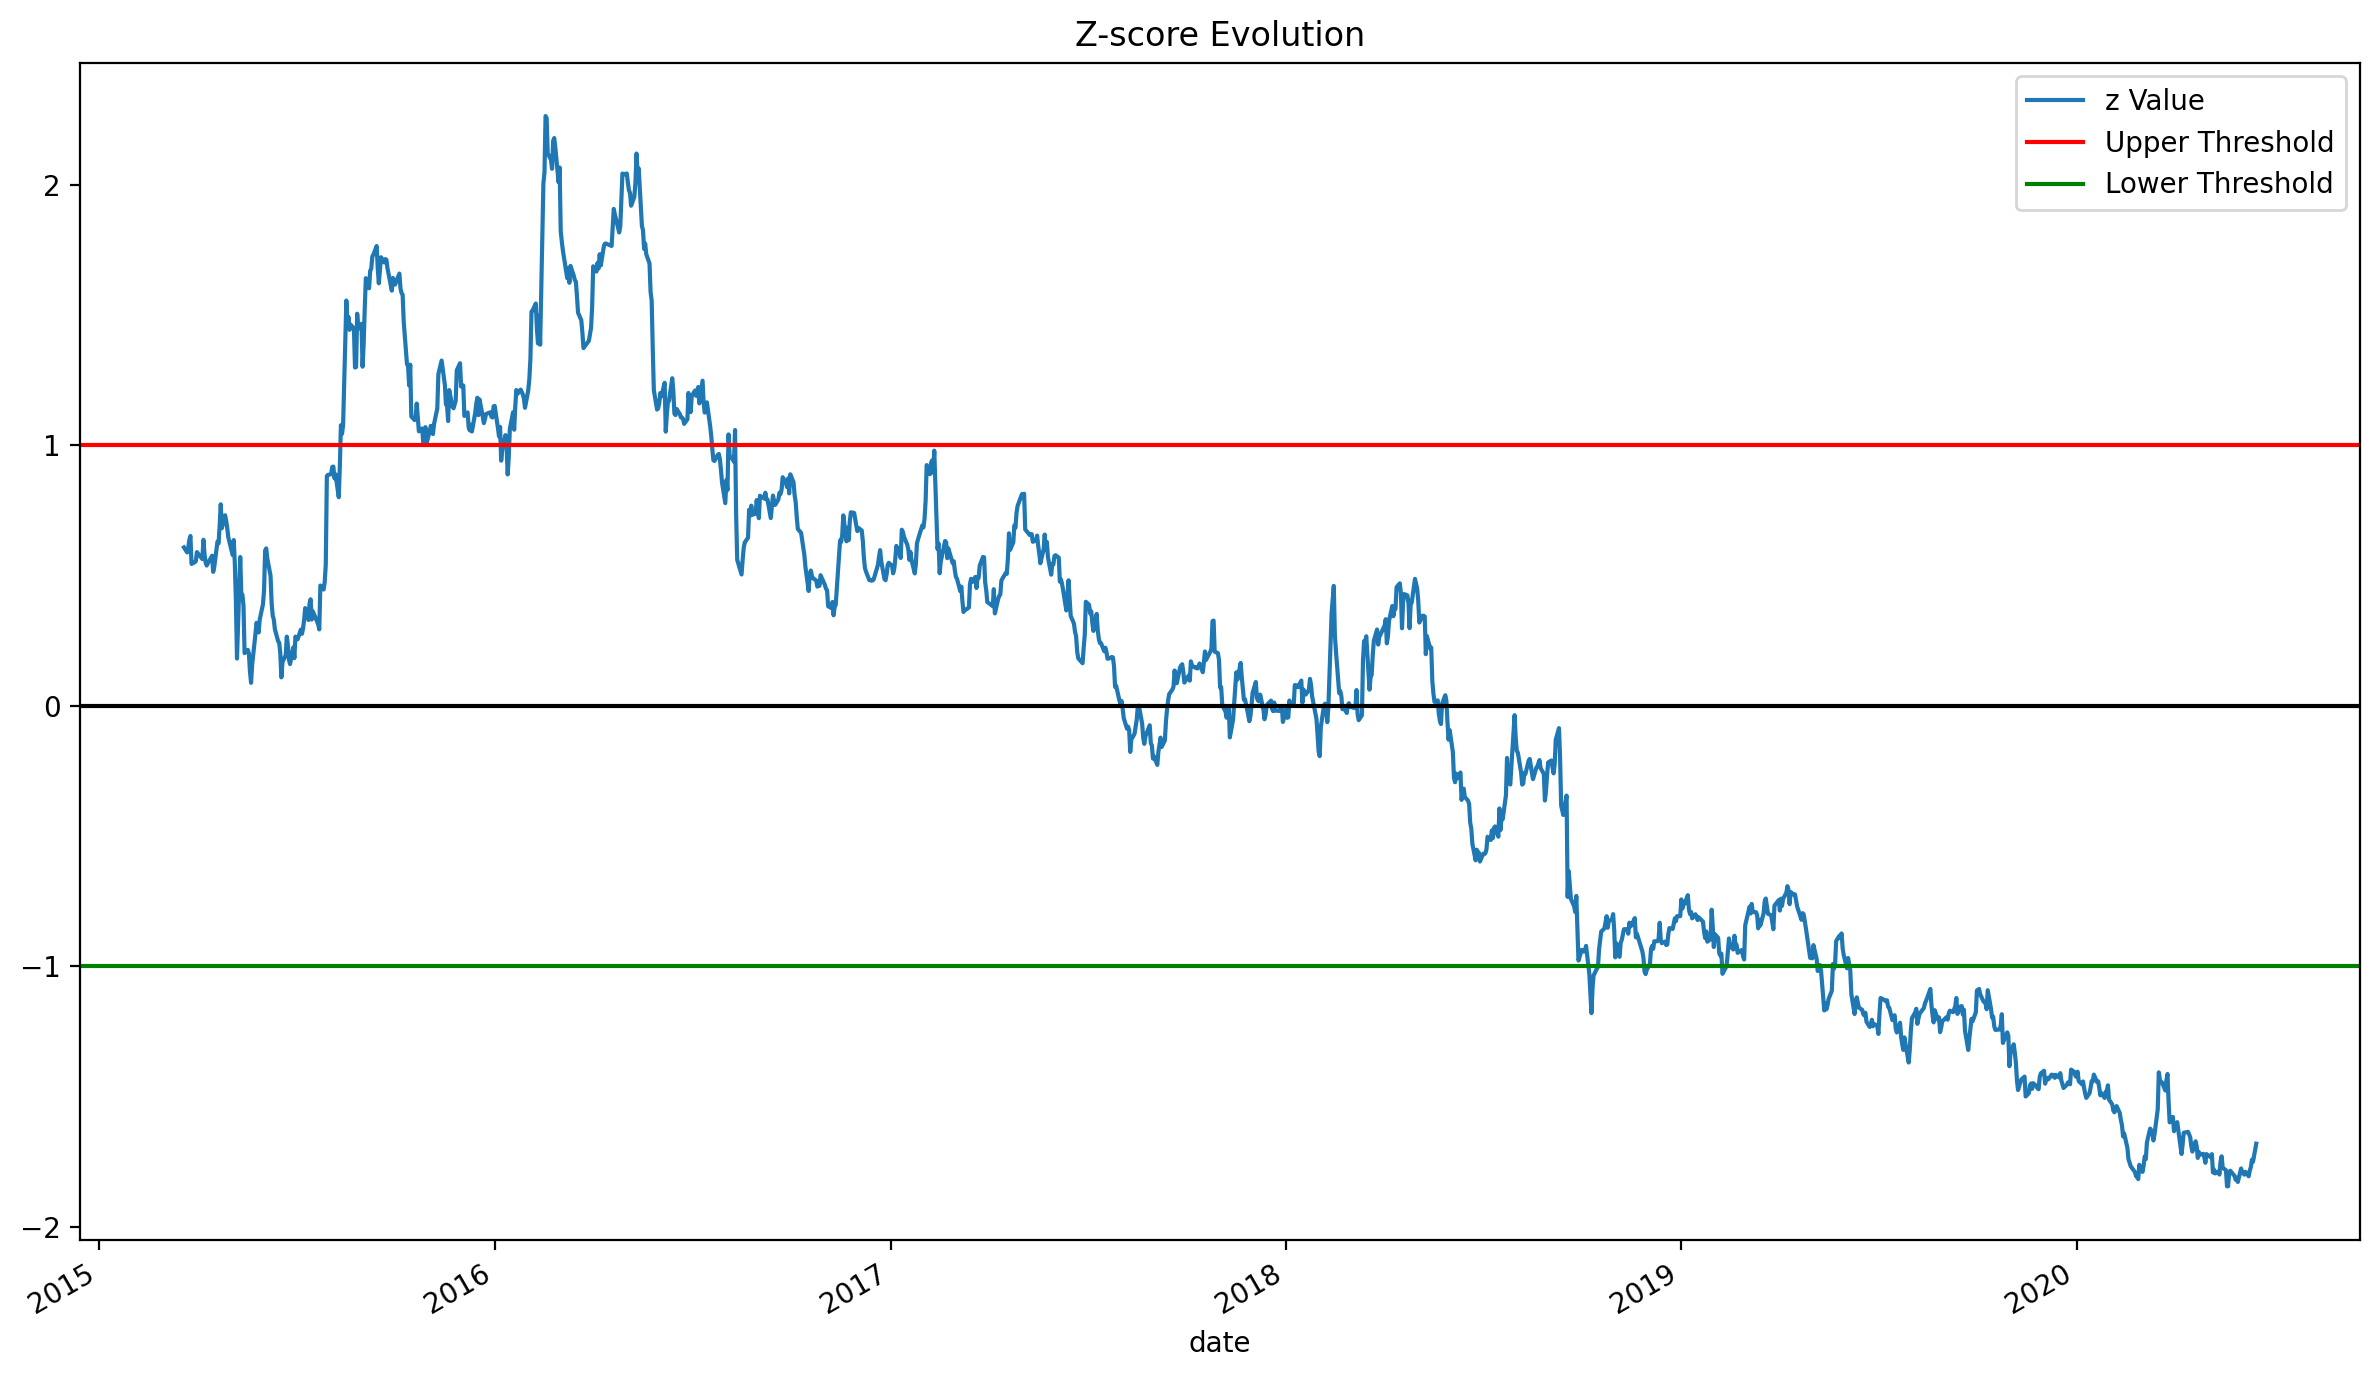

In [34]:
# visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evolution")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('images/chart6', dpi=300);

In [36]:
# verify dataframe head and tail
pd.concat([ signals.head(3), signals.tail(3) ])

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-03-20,167.573654,268.787994,0.607914,1.0,-1.0,0,NaN,0,NaN
2015-03-23,164.661880,265.407043,0.588593,1.0,-1.0,0,0.0,0,0.0
2015-03-24,162.963318,261.349823,0.608571,1.0,-1.0,0,0.0,0,0.0
2020-06-11,45.150002,177.149994,-1.742935,1.0,-1.0,1,0.0,-1,0.0
2020-06-12,45.450001,179.149994,-1.750402,1.0,-1.0,1,0.0,-1,0.0
2020-06-15,45.950001,173.699997,-1.681271,1.0,-1.0,1,0.0,-1,0.0


In [37]:
# check portfolio position
signals[signals.signals1 != 0].head(10)

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-08-12,174.784973,250.758850,1.077240,1.0,-1.0,-1,-1.0,1,1.0
2015-08-13,175.479935,253.644485,1.044138,1.0,-1.0,-1,0.0,1,0.0
2015-08-14,183.074966,262.643829,1.077383,1.0,-1.0,-1,0.0,1,0.0
2015-08-17,211.270905,273.648499,1.555787,1.0,-1.0,-1,0.0,1,0.0
2015-08-18,211.370178,278.588318,1.470744,1.0,-1.0,-1,0.0,1,0.0
2015-08-19,207.250000,271.936646,1.492476,1.0,-1.0,-1,0.0,1,0.0
2015-08-20,199.654968,264.649109,1.443286,1.0,-1.0,-1,0.0,1,0.0
2015-08-21,198.215378,261.665649,1.463059,1.0,-1.0,-1,0.0,1,0.0
2015-08-24,181.287903,240.047668,1.448404,1.0,-1.0,-1,0.0,1,0.0


In [40]:
pd.concat([signals[signals.positions1 != 0].head(), signals[signals.positions1 != 0].tail()])

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2015-03-20,167.573654,268.787994,0.607914,1.0,-1.0,0,NaN,0,NaN
2015-08-12,174.784973,250.758850,1.077240,1.0,-1.0,-1,-1.0,1,1.0
2016-01-07,138.497604,204.979584,0.941009,1.0,-1.0,0,1.0,0,-1.0
2016-01-11,138.100479,199.844101,1.039079,1.0,-1.0,-1,-1.0,1,1.0
2016-01-12,133.533539,195.050964,0.998050,1.0,-1.0,0,1.0,0,-1.0
2019-05-22,126.150002,341.100006,-1.009666,1.0,-1.0,1,1.0,-1,-1.0
2019-05-23,127.550003,342.200012,-0.991154,1.0,-1.0,0,-1.0,0,1.0
2019-06-03,131.550003,355.450012,-1.007999,1.0,-1.0,1,1.0,-1,-1.0
2019-06-04,132.600006,352.399994,-0.968564,1.0,-1.0,0,-1.0,0,1.0


In [41]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

asset1
138.497604    1
133.533539    1
156.417908    1
156.517181    1
144.901260    1
97.500000     1
104.750000    1
104.900002    1
112.550003    1
113.650002    1
126.150002    1
131.550003    1
124.349998    1
Name: count, dtype: int64

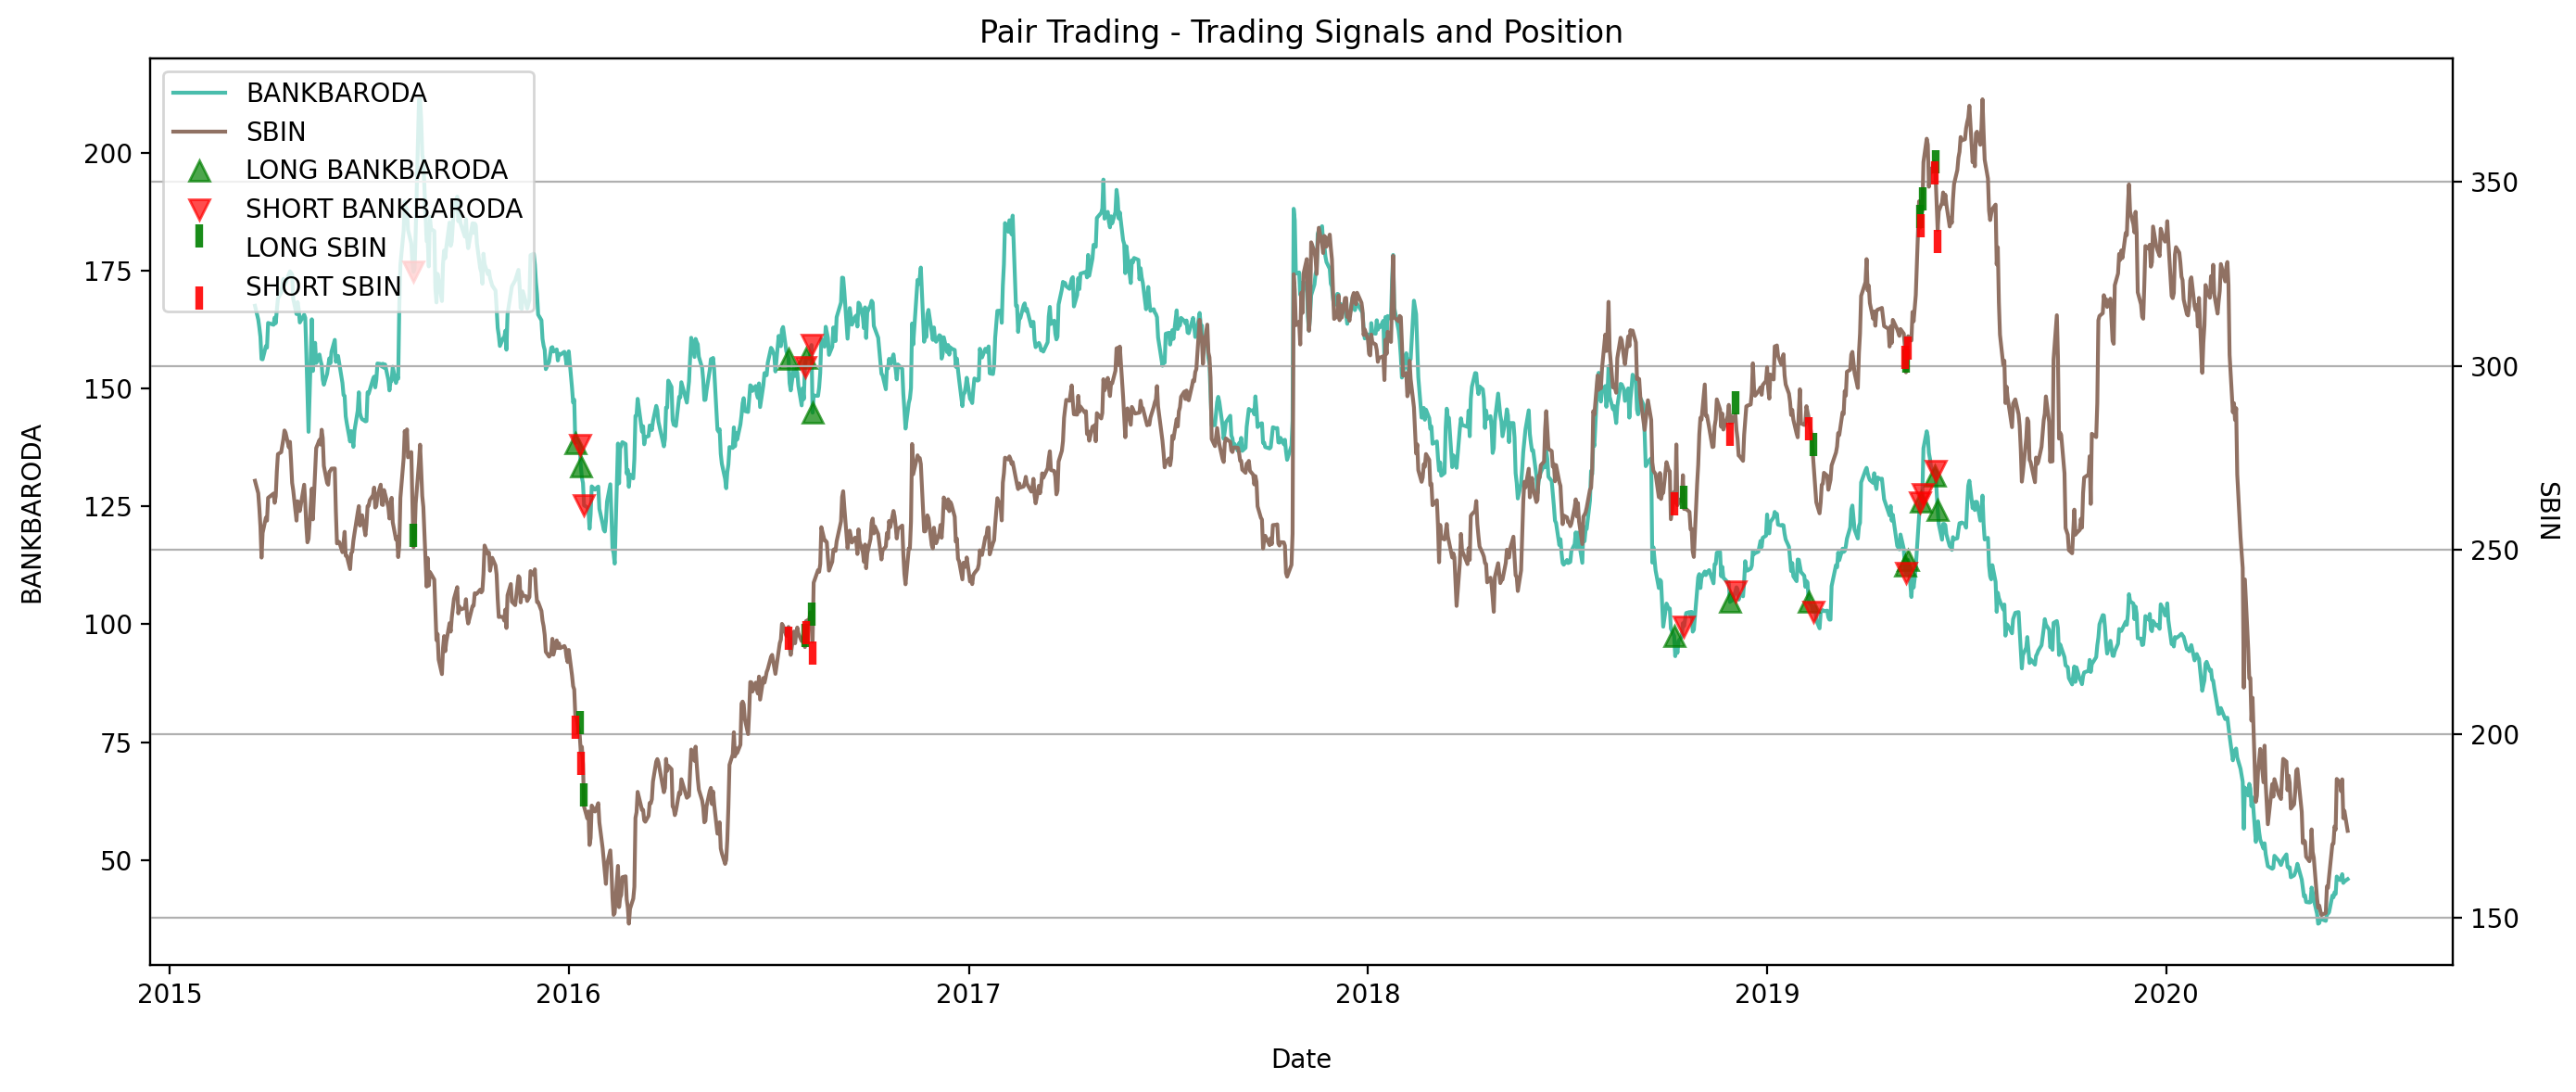

In [42]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/chart7', dpi=300);

## Portfolio Profit and Loss Calculation

We will start with an initial capital of 100,000 and calculate the maximum number of shares position for each stock using the initial capital. On any given day, total profit and loss from the first stock will be total holding in that stock and cash position for that stock. Similarly, profit and loss for the second stock will be total holding in the stock and cash for that stock. You need to keep in mind that we have a market neutral position which means we go long and short simultaneously with approximately the same capital. Finally, to get the total profit and loss we have to aggregate these two. Based on the position for the stock 1 and 2, we calculate their respective daily returns. We will also add a z-score column with upper and lower threshold columns to the final portfolio dataframe for visualization purposes.

Steps:
* We start with the initial capital of 100,000 and calculate the number of shares to buy for each stock.
* Next, we calculate holding in the first stock by taking the cumulative sum of its position multiplied by stock price and the total number of shares.
* We then calculate the cash position by subtracting holding from the initial cash position. The total position of stock in the portfolio is the sum of cash plus holding.
* Calculate daily returns using total stock position.
* Next, we follow the steps 1 to 4 for the second stock and sum up two asset’s positions for the total portfolio value.
* Add the z-score with upper and lower thresholds for visualization.
* Visualize the portfolio performance along with z-score, upper, and lower thresholds.
* Calculate portfolio CAGR.

In [43]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [44]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [46]:
pd.concat([portfolio.head(), portfolio.tail()])

,asset1,holdings1,cash1,total asset1,return1,positions1
date,,,,,,
2015-03-20,167.573654,NaN,NaN,NaN,NaN,NaN
2015-03-23,164.661880,0.000000,100000.000000,100000.000000,NaN,0.0
2015-03-24,162.963318,0.000000,100000.000000,100000.000000,0.000000,0.0
2015-03-25,160.973602,0.000000,100000.000000,100000.000000,0.000000,0.0
2015-03-26,156.266205,0.000000,100000.000000,100000.000000,0.000000,0.0
2020-06-09,45.799999,21663.399639,58773.202789,80436.602428,0.000294,0.0
2020-06-10,47.000000,22231.000000,58773.202789,81004.202789,0.007056,0.0
2020-06-11,45.150002,21355.950722,58773.202789,80129.153511,-0.010803,0.0
2020-06-12,45.450001,21497.850361,58773.202789,80271.053150,0.001771,0.0


In [47]:
portfolio[portfolio.positions1 != 0].head()

,asset1,holdings1,cash1,total asset1,return1,positions1
date,,,,,,
2015-03-20,167.573654,NaN,NaN,NaN,NaN,NaN
2015-08-12,174.784973,-82673.292297,182673.292297,100000.000000,0.000000e+00,-1.0
2016-01-07,138.497604,0.000000,117163.925430,117163.925430,3.828596e-02,1.0
2016-01-11,138.100479,-65321.526627,182485.452057,117163.925430,2.220446e-16,-1.0
2016-01-12,133.533539,0.000000,119324.088196,119324.088196,1.843710e-02,1.0


In [48]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [49]:
portfolio.to_csv('data/portfolio.csv')

pd.concat([portfolio.head(), portfolio.tail() ])

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2
date,,,,,,,,,,,,
2015-03-20,167.573654,NaN,NaN,NaN,NaN,NaN,268.787994,NaN,NaN,NaN,NaN,NaN
2015-03-23,164.661880,0.000000,100000.000000,100000.000000,NaN,0.0,265.407043,0.000000,100000.00000,100000.000000,NaN,0.0
2015-03-24,162.963318,0.000000,100000.000000,100000.000000,0.000000,0.0,261.349823,0.000000,100000.00000,100000.000000,0.000000,0.0
2015-03-25,160.973602,0.000000,100000.000000,100000.000000,0.000000,0.0,256.374969,0.000000,100000.00000,100000.000000,0.000000,0.0
2015-03-26,156.266205,0.000000,100000.000000,100000.000000,0.000000,0.0,247.922516,0.000000,100000.00000,100000.000000,0.000000,0.0
2020-06-09,45.799999,21663.399639,58773.202789,80436.602428,0.000294,0.0,184.449997,-49432.599182,188560.86908,139128.269897,0.004547,0.0
2020-06-10,47.000000,22231.000000,58773.202789,81004.202789,0.007056,0.0,187.699997,-50303.599182,188560.86908,138257.269897,-0.006260,0.0
2020-06-11,45.150002,21355.950722,58773.202789,80129.153511,-0.010803,0.0,177.149994,-47476.198364,188560.86908,141084.670715,0.020450,0.0
2020-06-12,45.450001,21497.850361,58773.202789,80271.053150,0.001771,0.0,179.149994,-48012.198364,188560.86908,140548.670715,-0.003799,0.0


In [50]:
portfolio[portfolio.positions2 != 0].head()

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2
date,,,,,,,,,,,,
2015-03-20,167.573654,NaN,NaN,NaN,NaN,NaN,268.787994,NaN,NaN,NaN,NaN,NaN
2015-08-12,174.784973,-82673.292297,182673.292297,100000.000000,0.000000e+00,-1.0,250.758850,67203.371826,32796.628174,100000.000000,0.000000,1.0
2016-01-07,138.497604,0.000000,117163.925430,117163.925430,3.828596e-02,1.0,204.979584,0.000000,87731.156616,87731.156616,-0.021348,-1.0
2016-01-11,138.100479,-65321.526627,182485.452057,117163.925430,2.220446e-16,-1.0,199.844101,53558.219055,34172.937561,87731.156616,0.000000,1.0
2016-01-12,133.533539,0.000000,119324.088196,119324.088196,1.843710e-02,1.0,195.050964,0.000000,86446.596008,86446.596008,-0.014642,-1.0


In [51]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

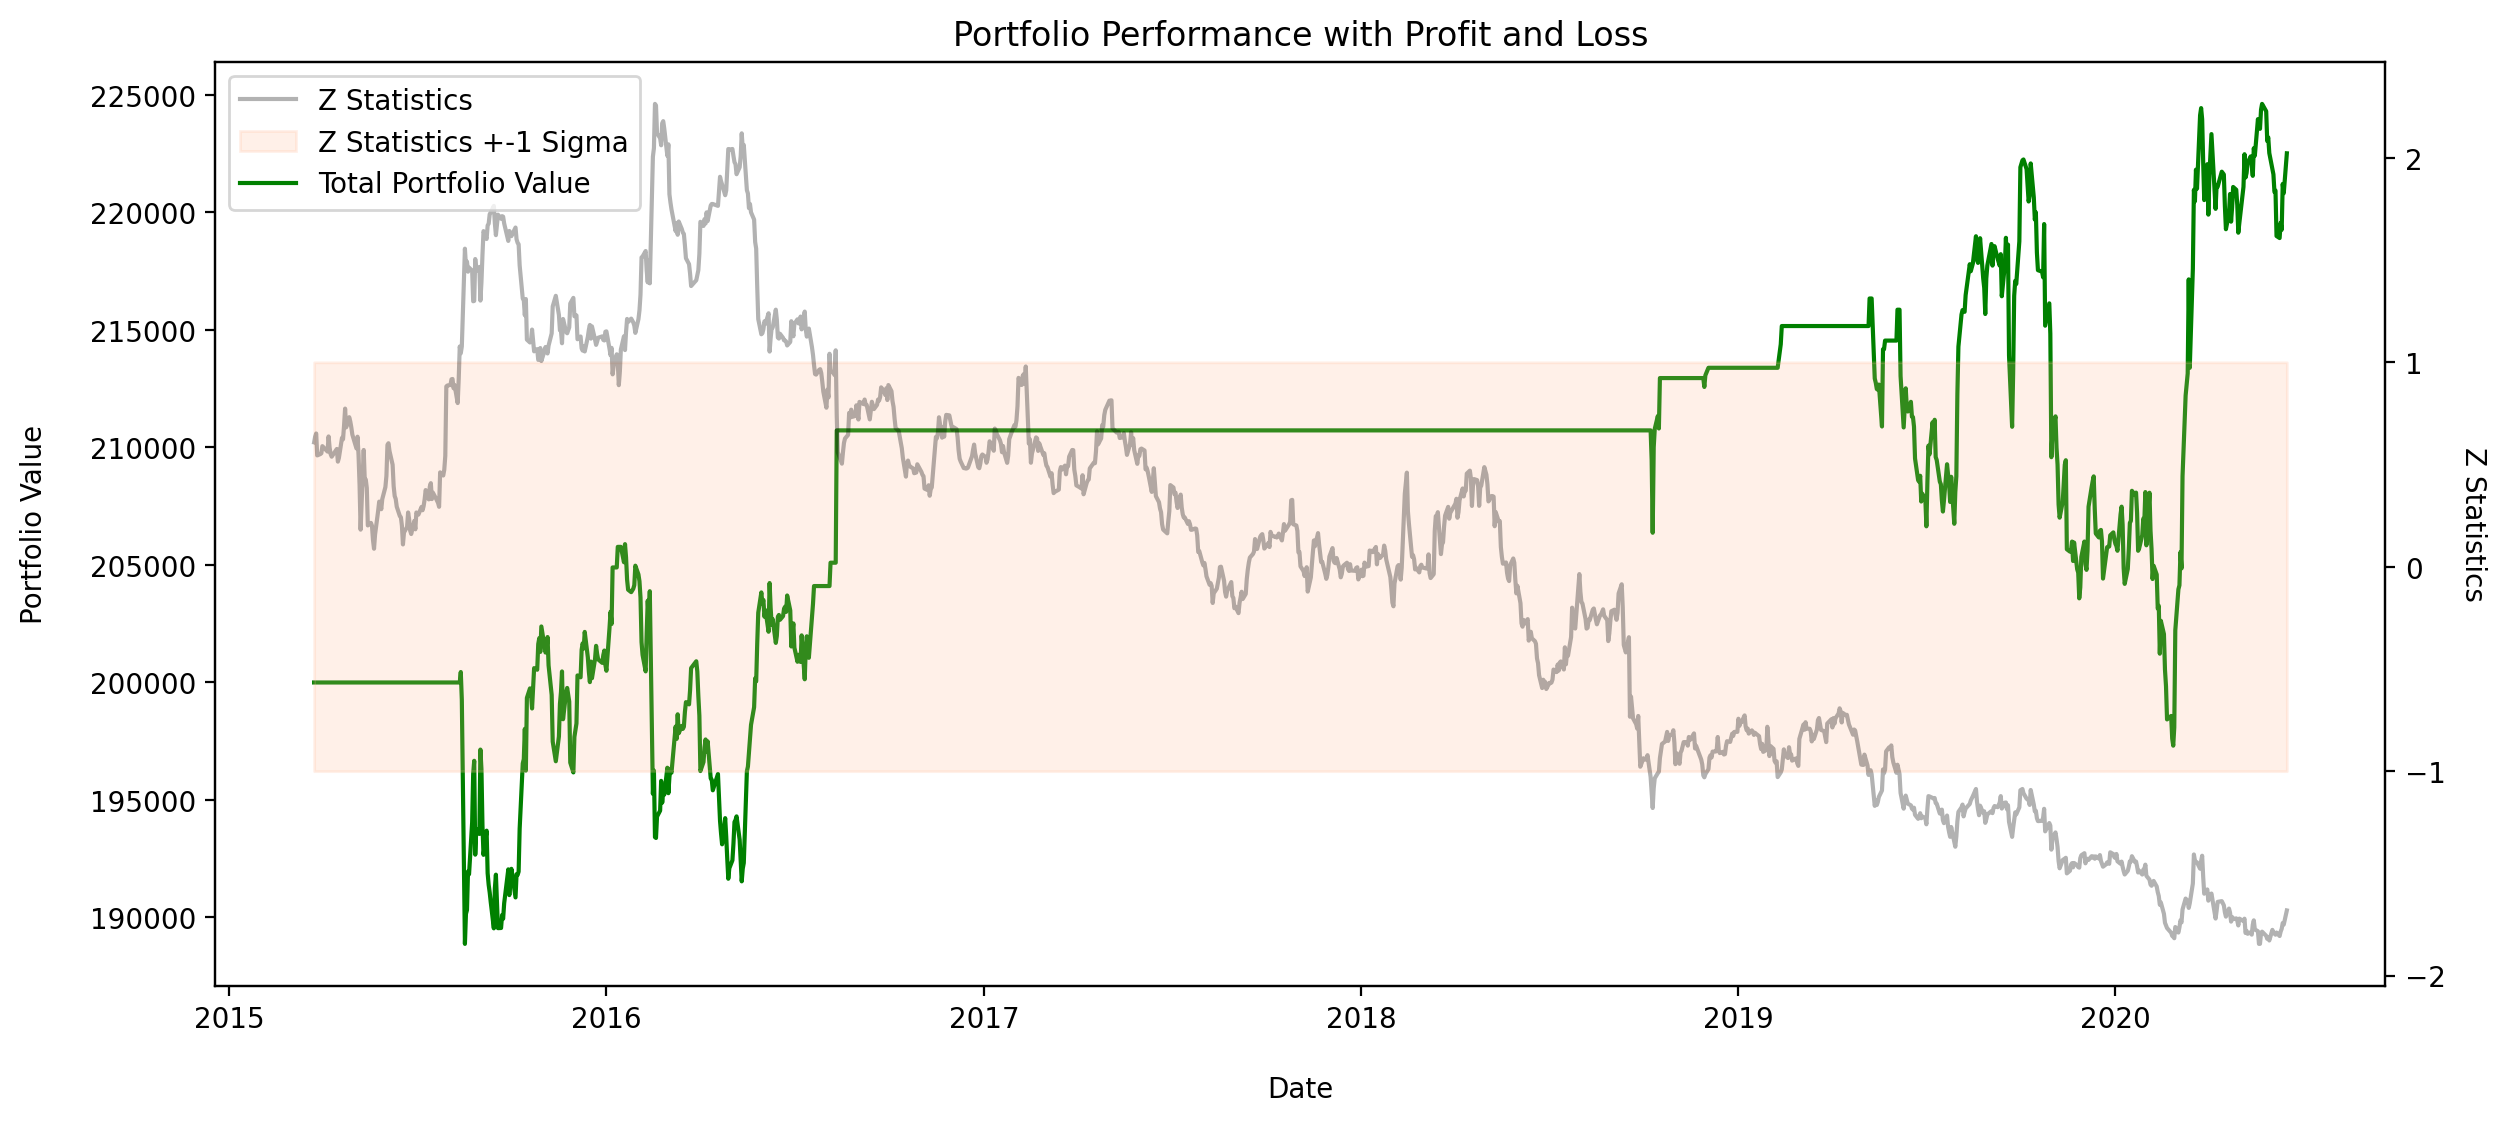

In [52]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('images/chart8', dpi=300);

In [53]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  1910


In [54]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 16.515%


The Compounded Annual Growth Rate (CAGR) for the strategy is 16.5% which looks promising however there are many things to consider before we draw any conclusion. Few important factors to account for are as follows:

1. As this is a market-neutral approach a lot depends on our ability to short sell which may be limited due to various reasons including regulations.
2. We have not accounted for costs related to trading, market slippage, and security borrowing. Normally, a market-neutral strategy results in a high number of trades.
3. There is always a limitation of using historical data to forecast the future.

Let’s keep in mind that any decision to implement a strategy should be based only after considering all the critical performance parameters including its feasibility and returns net of fee and charges.